# Problem 1

This problem is about checks that you can apply the singular value decomposition to a "new" problem, namely, the task of compressing an image.

There are six (6) exercises (0-5) worth a total of ten (10) points.

## Setup

Let's load some modules and an image, which you will use the SVD to compress.

In [1]:
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
from PIL import Image

def load_image_file (fn):
    return Image.open (fn, 'r')

def im2gnp (image):
    """Converts a PIL image into an image stored as a 2-D Numpy array in grayscale."""
    return np.array (image.convert ('L'))

def gnp2im (image_np):
    """Converts an image stored as a 2-D grayscale Numpy array into a PIL image."""
    return Image.fromarray (image_np.astype (np.uint8), mode='L')

def imshow_gray (im, ax=None):
    from matplotlib.pyplot import figure, axes, get_cmap
    if ax is None:
        f = figure ()
        ax = axes ()
    ax.imshow (im,
               interpolation='nearest',
               cmap=get_cmap ('gray'))

Let's download an image and represent it by a Numpy matrix, `img`.

In [3]:
urlretrieve ('https://cse6040.gatech.edu/datasets/Tech_Tower_1.jpg', 'tt1.jpg')
pic_raw = load_image_file ('tt1.jpg')

Next, let's convert this image to grayscale and print some stats, e.g., its dimensions and size (in pixels).

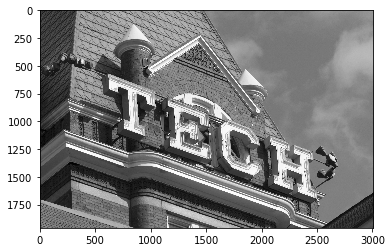

In [4]:
pic = im2gnp (pic_raw)
imshow_gray (pic)

**Exercise 0** (1 point). Write a function that, given a Numpy array-representation of a (grayscale) image, returns its size in pixels.

In [5]:
def sizeof_image (I):
    assert type (I) is np.ndarray
    assert len (I.shape) == 2
    #
    # YOUR CODE HERE
    #
    return I.shape[0]*I.shape[1]

In [6]:
pic_pixels = sizeof_image (pic)

print ("The image uses about {:.1f} megapixels.".format (1e-6 * pic_pixels))

assert pic_pixels == 5895680
print ("\n(Passed!)")

The image uses about 5.9 megapixels.

(Passed!)


## Compression via the truncated SVD

Recall that the $k$-truncated SVD gives the best rank-$k$ approximation to a matrix $A$. That is, if the SVD of $A$ is $A = U \Sigma V^T$, then we can approximate $A$ by

$$
  A \approx U_k \Sigma_k V_k^T,
$$

where $(U_k, \Sigma_k, V_k^T)$ is the $k$-truncated SVD, taken by retaining the $k$ largest singular values (entries of diagonal matrix $\Sigma$), as well as the first $k$ columns of the left and right singular vectors ($U$ and $V$).

Thus, if $A$ is the image then $(U_k, \Sigma_k, V_k^T)$ is a compressed representation of that image.

**Exercise 1** (2 point). Write a function, `compress_image(I, k)`, that compresses an input image `I` by interpreting `I` as a matrix, computing the `k`-truncated SVD, and returning a compressed representation.

For this function, we want you to return a tuple, `(S, Uk, VkT)`, where `S` is an array of _all_ the singular values (not just the top $k$) and `Uk` and `VkT` are the $k$-_truncated_ singular vectors.

In [7]:
def compress_image (I, k):
    #
    # YOUR CODE HERE
    #
    u,s,v=np.linalg.svd(I)
    Uk = u[:,:k]
    Vk = v[:k,]
    return s,Uk,Vk
# Runs your function:
k = 10
Sigma, Uk, VkT = compress_image (pic, k)

print (Sigma.shape)
print (Uk.shape)
print (VkT.shape)

(1960,)
(1960, 10)
(10, 3008)


In [8]:
assert Sigma.shape == (min (pic.shape),)
assert Uk.shape == (pic.shape[0], k)
assert VkT.shape == (k, pic.shape[1])
assert (Sigma[k:]**2).sum () <= 7e9

print ("\n(Passed!)")


(Passed!)


**Exercise 2** (1 point). Write a function, `sizeof_compressed_image()`, that returns the number of "equivalent pixels" used by the compressed (truncated SVD) representation.

What are "equivalent pixels?" Recall these facts:

- In the original grayscale image, only 1 byte is needed to store each pixel.
- In the (truncated) SVD representation, each matrix entry is a double-precision value, which requires 8 bytes.

In your implementation of this function, you may count just the $k$ largest singular values even though `compress_image` returns _all_ of the singular values.

In [9]:
def sizeof_compressed_image (Sigma, Uk, VkT):
    #
    # YOUR CODE HERE
    #
    return (Uk.shape[0]*Uk.shape[1]+VkT.shape[0]*VkT.shape[1]+k)*8


In [10]:
cmp_pixels = sizeof_compressed_image (Sigma, Uk, VkT)

print ("Original image required ~ {:.1f} megapixels.".format (1e-6 * pic_pixels))
print ("Compressed representation retaining k={} singular values is ~ {:.1f} megapixels.".format (k, 1e-6 * cmp_pixels))
print ("The compression ratio is {:.1f}x.".format (pic_pixels / cmp_pixels))

assert cmp_pixels == 397520
print ("\n(Passed!)")

Original image required ~ 5.9 megapixels.
Compressed representation retaining k=10 singular values is ~ 0.4 megapixels.
The compression ratio is 14.8x.

(Passed!)


**Exercise 3** (2 points). Recall that the error of the compressed representation, as measured in the squared Frobenius norm, is given by the sum of the trailing singular values,

$$
  \|A - U_k \Sigma_k V_k^T\|_F^2 = \sigma_{k}^2 + \sigma_{k+1}^2 + \cdots + \sigma_{s-1}^2,
$$

where $s = \min(m, n)$ if $A$ is $m \times n$ and we assume that the singular values are sorted from largest ($\sigma_0$) to smallest ($\sigma_{s-1}$).

Write a function that returns the _relative_ error, measured using the Frobenius norm, i.e.,

$$
  \dfrac{\|A - U_k \Sigma_k V_k^T\|_F}
        {\|A\|_F}
        .
$$

In [13]:
def compression_error (Sigma, k):
    """
    Given the singular values of a matrix, return the
    relative reconstruction error.
    """
    sig=Sigma[k:,]
    return np.linalg.norm(sig)/np.linalg.norm(Sigma)
    #
    # YOUR CODE HERE
    #


In [14]:
err = compression_error (Sigma, k)
print ("Relative reconstruction (compression) error is ~ {:.1f}%.".format (1e2*err))
assert err >= 0.25
print ("\n(Passed!)")

Relative reconstruction (compression) error is ~ 25.2%.

(Passed!)


**Exercise 4** (2 points). Write a function that, given the compressed representation of an image, reconstructs it approximately.

In [40]:
def uncompress_image (Sigma, Uk, VkT):
    #
    # YOUR CODE HERE
    #
    print(Uk.shape)
    print(Sigma.shape)
    print(VkT.shape)
    return np.dot(np.dot(Uk,np.diag(Sigma[:k])),VkT)


(1960, 10)
(1960,)
(10, 3008)
Measured relative error is ~ 25.2%.

(Passed!)


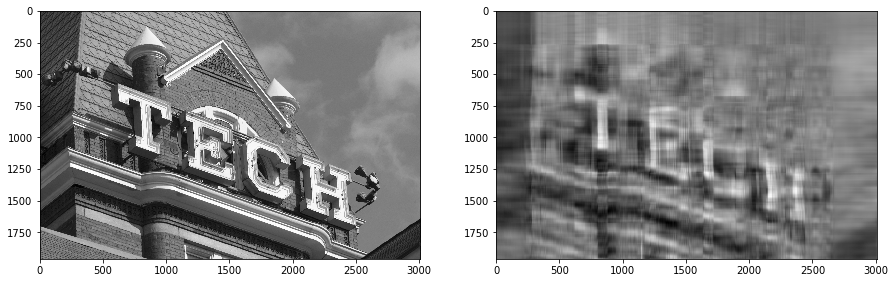

In [41]:
pic_lossy = uncompress_image (Sigma, Uk, VkT)

f, ax = plt.subplots (1, 2, figsize=(15, 30))
imshow_gray (pic, ax[0])
imshow_gray (pic_lossy, ax[1])

abs_err = np.linalg.norm (pic - pic_lossy, ord='fro')
rel_err = abs_err / np.linalg.norm (pic, ord='fro')
print ("Measured relative error is ~ {:.1f}%.".format (1e2 * rel_err))

pred_rel_err = compression_error (Sigma, k)
assert 0.95*pred_rel_err <= rel_err <= 1.05*pred_rel_err
print ("\n(Passed!)")

**Exercise 5** (2 points). Write a function that, given the singular values of an image, determines the truncation point, $k$, that would reduce the relative error below a desired threshold.

> _Hint:_ You may find Numpy's [cumulative sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) handy.

In [42]:
def find_rank (rel_err_target, Sigma):
    #
    # YOUR CODE HERE
    #
    for i in range(Sigma.shape[0]):
        ans=compression_error(Sigma, i)
        print(ans)
        if ans<rel_err_target:
            solution=i
            break
        
    return solution

In [43]:
rel_err_target = 0.15
k_target = find_rank (rel_err_target, Sigma)

print ("Relative error target:", rel_err_target)
print ("Suggested value of k:", k_target)

print ("Compressing...")
Sigma_target, Uk_target, VkT_target \
    = compress_image (pic, k_target)
target_pixels = sizeof_compressed_image (Sigma_target,
                                         Uk_target,
                                         VkT_target)
target_ratio = pic_pixels / target_pixels
print ("Estimated compression ratio: {:.1f}x".format (target_ratio))

pic_target = uncompress_image (Sigma_target, Uk_target, VkT_target)
f, ax = plt.subplots (1, 2, figsize=(15, 30))
imshow_gray (pic, ax[0])
imshow_gray (pic_target, ax[1])

assert compression_error (Sigma, k_target) <= rel_err_target
assert compression_error (Sigma, k_target-1) > rel_err_target

print ("\n(Passed!)")

1.0
0.377852120829
0.356523463917
0.337049200185
0.317537874609
0.302438380494
0.28858077753
0.278627781436
0.269388789005
0.260579766014
0.252053131345
0.24542638648
0.23908557967
0.23282663251
0.228019135518
0.223363112674
0.218932210535
0.214710688281
0.210567722202
0.206870843515
0.203284293782
0.200032498348
0.197094658003
0.194362949195
0.191648871809
0.189097094654
0.186664717927
0.184273955208
0.182087790947
0.179909090462
0.177850775383
0.17580948498
0.173794914085
0.171861195413
0.170002448055
0.16814113263
0.166355882293
0.164595850128
0.16283691612
0.161246245739
0.159673233835
0.158113502722
0.156577740253
0.155033420125
0.153572823856
0.152152796813
0.150740292943
0.149392352297
Relative error target: 0.15
Suggested value of k: 47
Compressing...
Estimated compression ratio: 3.2x
(1960, 47)
(1960,)
(47, 3008)


ValueError: shapes (1960,47) and (10,10) not aligned: 47 (dim 1) != 10 (dim 0)

**Fin!** If you've reached this point and all tests above pass, you are ready to submit your solution to this problem. Don't forget to save you work prior to submitting.